# Weather Pattern Analysis using HMM

## Importing libraries

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score
from scipy.stats import mode

## Data Preparation

In [2]:
np.random.seed(42)

### States and Transition Matrix

In [3]:
states = ['sunny','cloudy','rainy']
n_states = len(states)

In [5]:
trans_mat = np.array([
    [0.7,0.2,0.1],
    [0.3,0.4,0.3],
    [0.2,0.3,0.5],
])

In [7]:
covs = {
    'sunny':[[5,2],[2,3]],
    'cloudy':[[4,1],[1,4]],
    'rainy': [[3,1],[1,3]]
}

In [8]:
means = {
    'sunny' : [30,30],
    'cloudy' : [22,50],
    'rainy':[18,80]
}

### Synthetic data creation

In [12]:
def simulate_weather_sequence(n_days = 300):
    hidden_states = []
    observations = []

    current_state = np.random.choice(n_states)
    for _ in range(n_days):
        state_name = states[current_state]
        hidden_states.append(current_state)

        obs = np.random.multivariate_normal(means[state_name],covs[state_name])
        observations.append(obs)

        current_state = np.random.choice(n_states,p=trans_mat[current_state])

    return np.array(hidden_states),np.array(observations)

In [13]:
true_states,observations = simulate_weather_sequence()

## HMM Model

### Discrete HMM

In [14]:
discretizer = KBinsDiscretizer(n_bins = 4,encode='ordinal',strategy='uniform')
discrete_obs = discretizer.fit_transform(observations).astype(int)
obs_sybols = (discrete_obs[:,0]*4 + discrete_obs[:,1].reshape(-1,1))

In [15]:
model_discrete = hmm.MultinomialHMM(n_components = n_states,n_iter= 1000,random_state=42)
model_discrete.fit(obs_sybols)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


MultinomialHMM(n_components=3, n_iter=1000,
               n_trials=array([1920, 1920, 1920, 2220, 2220, 2220, 2220, 2220, 1920, 1920, 1920,
       2220, 2220, 2820, 2820, 2820, 2820, 2220, 1920, 1920, 1920, 2820,
       1920, 1920, 1920, 2220, 1920, 1920, 1920, 1920, 2820, 2820, 1920,
       1920, 1920, 1920, 1920, 1920, 1920, 1920, 1920, 1920, 1920, 1920,
       1920, 1920, 1920, 2220, 2220, 2220, 2820, 2820, 2820, 2220, 1920,
       2820, 2820, 2820, 22...
       2220, 2820, 2820, 1920, 1920, 2820, 2820, 2220, 2220, 2220, 2820,
       2820, 2220, 1920, 2220, 2220, 1920, 1920, 2220, 2820, 2820, 2220,
       2820, 2820, 2220, 1920, 2220, 1920, 2820, 2220, 2220, 2220, 2820,
       2820, 2220, 2220, 1920, 2220, 2220, 2220, 2220, 1920, 2820, 2820,
       1920, 1920, 2220, 2220, 2820, 1920, 2220, 1920, 2220, 2820, 1920,
       1920, 1920, 1920, 2220, 2220, 2220, 2820, 2220, 2220, 2220, 2220,
       1920, 2820, 2820]),
               random_state=RandomState(MT19937) at 0x1DB1766F840)

In [17]:
pred_states_d = model_discrete.predict(obs_sybols)

### Continuous HMM

In [21]:
model_continuous = hmm.GaussianHMM(n_components= n_states,covariance_type='full',n_iter = 1000,random_state=42)
model_continuous.fit(observations)

GaussianHMM(covariance_type='full', n_components=3, n_iter=1000,
            random_state=42)

In [22]:
pred_state_c = model_continuous.predict(observations)

## States mapping and Evaluation

In [23]:
def map_states(true,pred):
    mapping = {}
    for s in range(n_states):
        idx = np.where(pred==s)
        if len(idx[0]) > 0:
            mapping[s] = mode(true[idx],keepdims=True).mode[0]
    remapped = np.vectorize(lambda x: mapping.get(x,x))(pred)
    return remapped

In [25]:
remapped_discrete = map_states(true_states,pred_states_d)
remapped_continuous = map_states(true_states,pred_state_c)

In [26]:
acc_d = accuracy_score(true_states,remapped_discrete)
acc_c = accuracy_score(true_states,remapped_continuous)

In [27]:
print(f"Acuracy of Discrete HMM : {acc_d:.2f}")
print(f"Acuracy of Continuous HMM : {acc_c:.2f}")

Acuracy of Discrete HMM : 0.78
Acuracy of Continuous HMM : 0.78


## Visualization

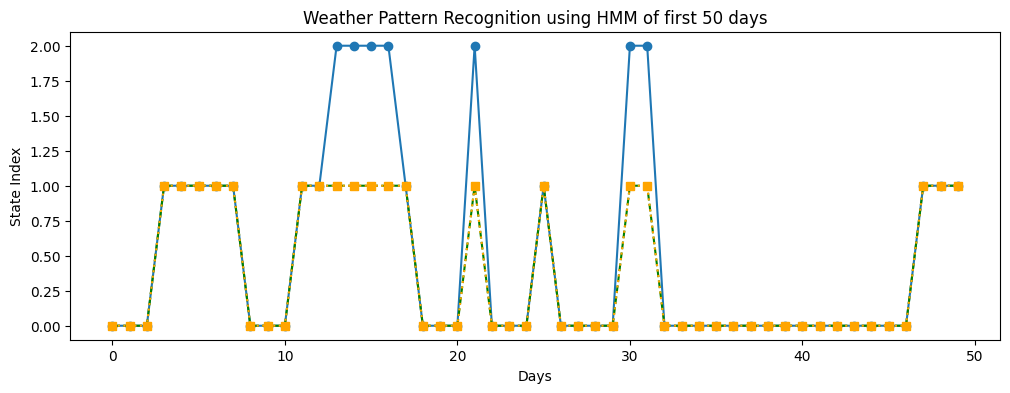

In [41]:
plt.figure(figsize=(12,4))
plt.plot(true_states[:50],label='True States',marker='o')
plt.plot(remapped_discrete[:50],label='DHMM',marker='x',linestyle='--',color='green')
plt.plot(remapped_continuous[:50],label='CHMM',marker='s',linestyle=':',color='orange')

plt.title('Weather Pattern Recognition using HMM of first 50 days')
plt.xlabel('Days')
plt.ylabel("State Index")
plt.show()
